In [1]:
!wget http://dtn-max.ifa.hawaii.edu/SpaceApps/2024/spaceappschallenge_seismicdetection_data.zip

--2024-10-06 04:49:05--  http://dtn-max.ifa.hawaii.edu/SpaceApps/2024/spaceappschallenge_seismicdetection_data.zip
Resolving dtn-max.ifa.hawaii.edu (dtn-max.ifa.hawaii.edu)... 206.196.177.123
Connecting to dtn-max.ifa.hawaii.edu (dtn-max.ifa.hawaii.edu)|206.196.177.123|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 756718846 (722M) [application/zip]
Saving to: ‘spaceappschallenge_seismicdetection_data.zip.1’

spaceappschallenge_ 100%[===================>] 721.66M  75.6MB/s    in 12s     

2024-10-06 04:49:19 (58.9 MB/s) - ‘spaceappschallenge_seismicdetection_data.zip.1’ saved [756718846/756718846]



In [ ]:
!unzip spaceappschallenge_seismicdetection_data.zip

In [ ]:
%cd /content
!ls

In [ ]:
#Install prerequisite packages
%pip install obspy


In [1]:
#Import modules
import numpy as np
import pandas as pd
import scipy
from scipy.signal import hilbert,find_peaks
from scipy.interpolate import UnivariateSpline
import obspy
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
import typing
from typing import *
%matplotlib inline

In [2]:
#GLOBAL VARIABLES
DATASET_ROOT_PATH="data"

In [3]:
#Dataset
'''
class to assimilate data ,
Input: paths to dataset
Output: Multi-dim matrix,  np.ndarray or torch.tensor
'''
class SeismicDataset:

  def __init__(self,dataset_root:str)->None:
    self.dataset_root=dataset_root
    self.list_of_planets=["lunar","mars"]
    self.modes=["train","test"]

  def loadDataset(self,pad_seq=False,ohe=False,n_classes:Optional[int]=1)->np.ndarray:
      '''
      dataset of shape (Number of samples, timestamps)
      '''
      signal_stack=[]
      labels=[]
      sampling_rate=[]

      for i,row in self.dataset.iterrows():
        filename=row["filename"]
        time_rel=row["time_rel(sec)"]
        signal = obspy.read(filename + ".mseed")
        signal_stack.append(signal[0].data)
        labels.append(time_rel)
        sampling_rate.append(signal[0].stats.sampling_rate)
      if pad_seq:
        signal_stack=self.padSequences(signal_stack)
      if ohe:
        labels=self.one_hot_encode(labels,n_classes)
      return signal_stack, labels, sampling_rate

  def one_hot_encode(self,array:np.ndarray, num_classes:int):
    # Create a zero array of shape (array_len, num_classes)
    n_samples=len(array)
    sample_hist={}
    for sample in train_data:
      maxlen=max(sample.shape)
      if maxlen not in sample_hist.keys():
        sample_hist[maxlen]=1
      else:
        sample_hist[maxlen]+=1

    maxlen=max(sample_hist.keys())

    one_hot = np.zeros((n_samples,maxlen))

    # Use NumPy's advanced indexing to place 1s
    one_hot[:,np.array(array,dtype=np.uint32)] = 1
    return one_hot

  def padSequences(self,train_data):

    sample_hist={}
    for sample in train_data:
      maxlen=max(sample.shape)
      if maxlen not in sample_hist.keys():
        sample_hist[maxlen]=1
      else:
        sample_hist[maxlen]+=1

    maxlen=max(sample_hist.keys())
    x_train=np.zeros((len(train_data),maxlen))
    for i,xsample in enumerate(train_data):
      clen=len(xsample)
      x_train[i,:clen]=xsample[:clen]
    return x_train

  def generatePathToLogs(self)->None:
    '''
    returns a DataFrame with columns: filename,logname,time_rel(label)
    '''
    # Extract Catalog for time_rel aka label data
    database_roots={"catalog":
                    {"lunar":
                    {"train":"lunar/catalog"},
                    "mars":
                    {"train":"mars/catalog"}
                    }
                  }
    list_of_csvs_path=[]
    for planet_data in database_roots.values():
      for planet,data_cap in planet_data.items():
        for data_category,path in data_cap.items():
          path1=os.path.join(self.dataset_root,path)
          list_dirs=os.listdir(path1)
          for csvpath in list_dirs:
              path2=os.path.join(path1,csvpath)
              assert os.path.isfile(path2), "Path not found"
              list_of_csvs_path.append(path2)

    catalog=[]

    for csv_path in list_of_csvs_path:
      df=pd.read_csv(csv_path)
      df["logname"]=df["filename"].apply(lambda name: name.strip(".csv").strip(".mseed"))

      df.name="_".join(csv_path.split("/")[1:3])
      catalog.append(df)
    lunar_catalog=catalog[0]
    mars_catalog=pd.merge(catalog[1],catalog[2])
    #Extract signal data

    database_roots={"data":
                  {"lunar":
                  {"train":"lunar/train",
                  "test":"lunar/test"},
                  "mars":
                  {"train":"mars/train",
                  "test":"mars/test"}
                  }
                }
    list_of_csvs=[]

    for planet_data in database_roots.values():
        for planet,data_cap in planet_data.items():
            for data_category,path in data_cap.items():
                path1=os.path.join(self.dataset_root,path)
                scandir=os.scandir(path1)
                respaths=[]
                lognames=[]
                for sample in scandir:

                  res_path=os.path.join(path1,sample.name.strip(".csv").strip(".mseed"))
                  log_name=sample.name.strip(".csv").strip(".mseed")
                  respaths.append(res_path)
                  lognames.append(log_name)

                df=pd.DataFrame({"filename":respaths,"logname":lognames})
                df.attrs["metadata"]={"name":planet,"type":data_category}
                list_of_csvs.append(df)
                del df

    lunar_train_signals_table=list_of_csvs[0]
    lunar_test_signals_table=list_of_csvs[1]
    mars_train_signals_table=list_of_csvs[2]
    mars_test_signals_table=list_of_csvs[3]
    # Perform an inner join with logname to get a dataframe
    lunar_training_data=pd.merge(lunar_train_signals_table,lunar_catalog, on='logname')
    lunar_training_data=lunar_training_data.drop(columns=["filename_y"])
    lunar_training_data=lunar_training_data.rename(columns={"filename_x":"filename"})

    self.dataset=lunar_training_data


'''
Test block
'''
dataTester=SeismicDataset(DATASET_ROOT_PATH)
dataTester.generatePathToLogs()
train_data,train_labels,sampling_rate=dataTester.loadDataset()
x_train,x_label,_=dataTester.loadDataset(pad_seq=True,ohe=True,n_classes=1)

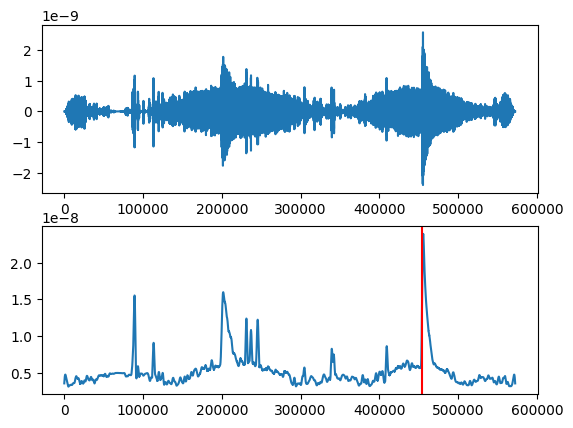

In [4]:
#PreProcessing
'''
Input:Signal
Output: Transformed / Augmented data
'''
class ProcessSignal:
  def __init__(self)->None:
    pass

  def prefilter(self,x:np.ndarray,fs:float, cutoff:float)->None:

    # Take absolute value
    x_abs = np.abs(x)

    # Design low-pass filter
    normal_cutoff = cutoff / (0.5*fs)
    b, a = scipy.signal.butter(2, normal_cutoff, btype='low', analog=False)

    # Apply filter
    envelope = scipy.signal.filtfilt(b, a, x_abs)

    #
    return envelope

  def detectEnvelope(self,x:np.ndarray,N:int,method = 'analytic', window="hamming",prefilter_req=False):
    if prefilter_req:
      x=self.prefilter(x,fs,1)
    x=np.abs(x)
    #Assert that x is a 1D numpy array
    kernel_mapper={"rect":np.ones(N)/N,"hamming":np.hamming(N),"hanning":np.hanning(N),"blackman":np.blackman(N),
                  "gaussian":scipy.signal.windows.gaussian(N,1),"tukey":scipy.signal.windows.tukey(N,1)}
    if method == 'analytic':

      #Calculate the mean of x and remove it
      x_mean = np.mean(x)
      x_zero_mean = x-x_mean

      #Take the absolute value of the Hilbert transform
      #to calculate the analytical envelope of the zero mean
      #version of x
      zero_mean_envelope = np.abs(hilbert(x_zero_mean,N = N))

      #Calculate and return upper and lower envelopes
      return x_mean+zero_mean_envelope,x_mean-zero_mean_envelope

    elif method == 'rms':

      #Assert that N is specified and is an integer
      #For the rms method N serves as window size
      #for the moving average
      assert N and isinstance(N,int), 'N must be an integer'

      #Calculate the mean of x and remove it
      x_mean = np.mean(x)
      x_zero_mean = x-x_mean
      #Moving average is calculated using np.convolve


      #Calculate the RMS envelope of the zero mean version of x.
      kernel=kernel_mapper[window]
      #Moving average is calculated using np.convolve
      zero_mean_envelope = np.sqrt(np.convolve(x_zero_mean**2,kernel,mode = 'same'))

      #Calculate and return upper and lower envelopes
      return x_mean+zero_mean_envelope,x_mean-zero_mean_envelope

    elif method == 'peak':

      #Assert that N is specified and is an integer
      #For the peak method N serves as the minimum number of
      #samples that seperate local maxima
      assert N and isinstance(N,int), 'N must be an integer'

      #Calculate local maxima and minima which will serve
      #as peaks for upper and lower envelopes respectively
      peaks_upper,_ = find_peaks(x,distance = N)
      peaks_lower,_ = find_peaks(-x,distance = N)

      #Calculate upper and lower envelopes by interpolating
      #peaks using a Univariate spline
      upper_spline = UnivariateSpline(peaks_upper,x[peaks_upper])
      lower_spline = UnivariateSpline(peaks_lower,x[peaks_lower])
      upper_envelope = upper_spline(np.arange(x.shape[0]))
      lower_envelope = lower_spline(np.arange(x.shape[0]))

      #Return the envelopes
      return upper_envelope,lower_envelope

    else:

      raise ValueError('%s is not a valid method' %(method))

  def compareSignals(self,original:np.ndarray,signal:np.ndarray,fs:float,arrival_time:float,block:Optional[bool]=True)->None:

    plt.close()
    plt.subplot(2,1,1)
    plt.plot(original)
    plt.subplot(2,1,2)
    plt.plot(signal)
    plt.axvline(x=(arrival_time*fs),color="red")
    plt.show()
  '''
  Test block
  '''
#36
#51
#16
#21
#24
#39
#46

idx=10
x_input,x_label,fs=train_data[idx],train_labels[idx],sampling_rate[idx]
p=ProcessSignal()
envelope=p.detectEnvelope(x_input,int(fs*512),'rms',"hamming",True)
p.compareSignals(x_input,envelope[0],fs,x_label)


In [5]:
def convert_to_batches_of_data(data,batches):

  nsamples,ntimestamps=data.shape
  data=data[:,:int(ntimestamps/batches)*batches]

  data=data.reshape(nsamples,int(ntimestamps/batches),batches)
  data=data.reshape(nsamples*int(ntimestamps/batches),-1)

  return data
x_input=convert_to_batches_of_data(x_train,100)

In [ ]:
# Model Training
'''
Define optimizers, hyperparams,
Start/end Training, store model checkpoint

'''

In [ ]:
#Evaluation
'''
Input: Model, test data
Output: pd.Dataframe or similar table with evaluation results
'''

In [ ]:
#Demo app
'''
Input: Model, sample input signal
'''